In [15]:
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import NaN
from functions import * # import functions from the .py file

from pylab import rcParams
rcParams["figure.figsize"] = 16, 4

PAYLOADSIZE = 14

if PAYLOADSIZE % 2 != 0:
    print("Alarm! the payload size is not even.")
NUM_16RND = (PAYLOADSIZE-2)//2 # how many 16 bits random number included in each frame
MAX_SEQ = 256 # (decimal) maximum seq number defined by the length of the seq, the length of seq is 1B

## Log file

**For a fair comparison between groups, must follow the output format below**
<br>$\color{red}{\text{timestamp\_rx }| \text{ len [hex] } \text{ seq [hex] } \text{ payload [hex] }| \text{rssi} }$
<br>$\text{ len [hex]}$ = payload length + 1 (seq. field length [1B])
<br>$\text{ payload [hex]}$ should start with the pseudo sequence number [2B], indicates the starting byte's position in the file.
***
*Example log file output for one frame with reciever timestamp xxxx, frame length, seq number and random payload, received signal strength.*
<br>15:17:18.394 |0f 46 bd f8 f7 ea 41 ac 1b be 05 a0 7f d2 09 d4 |  -91 CRC error
<br>$\color{red}{\text{delimiter for four variables is "|" and delimiter for the payload each byte is the space " ".}}$

In [16]:
# define the file name
filename = "test4"
# import file to jupyter notebook
df = readfile("./" + filename + ".txt")
# check the imported data first 10 lines
df.head(10)

,index,time_rx,rssi,seq,payload
0,0,2025-05-07 00:00:21.357,-90,4,08 d4 15 e9 22 16 1b 2c 29 3a 5a f6 1f 6d e2 6...
1,1,2025-05-07 00:00:23.439,-89,30,2c 38 1f 8d 19 c8 61 1c 7b e4 7e f0 87 cc 10 6...
2,4,2025-05-07 00:00:25.015,-88,149,06 fc 27 ce 1a 4b 1a f2 1d 1b 1b 8c 18 0a
3,5,2025-05-07 00:00:25.281,-87,150,07 08 21 0b 29 33 15 d6 1b 02 1c ce 14 d6
4,6,2025-05-07 00:00:25.547,-86,151,07 14 22 9b 0c dc 20 e3 26 46 26 2f 22 c9
5,7,2025-05-07 00:00:26.073,-88,153,87 2c 23 b0 1e d9 60 df 1c fa 10 9e 15 1f
6,8,2025-05-07 00:00:26.339,-83,154,07 38 15 a2 1b f5 2c e2 1b 7f 23 31 25 a3
7,9,2025-05-07 00:00:26.605,-83,155,07 44 22 74 17 ff 20 69 1f ec 1c d2 20 d2
8,10,2025-05-07 00:00:26.871,-85,156,07 50 1f 7e 18 65 26 90 20 37 23 2a 24 99
9,11,2025-05-07 00:00:27.138,-89,157,07 5c 1c 2d 22 44 1b f1 21 de 28 81 1e 3c


In [17]:
# delete packets of invalid length (aka. error in length field at variable receiver length config) (PAYLOADSIZE + 2B pesudo sequence number)
test = df[df.payload.apply(lambda x: len(x)==((PAYLOADSIZE)*3-1))]
test.reset_index(inplace=True)
print(len(test))

194


# Time

## Definition

**Evaluation metric**
<br>*File Transmission Time: the total latency that certain amount of Data $F$ is delivered to the destination.*
<br> $File\ Delay = Rx\_timestamp[N] - Rx\_timestamp[0]$
<br> where $N$ is the last packet
***
**Interesting to look at**:
<br>*Timestamp difference*: $\Delta T[i] = Rx\_timestamp[i] - Tx\_timestamp[i]$
1. *Worst-case packet delay*: the delay of the packet that takes the longest time to traverse.
2. *Packet delay variation*: the std of the packet delay.

In [18]:
# compute the file delay
file_delay = df.time_rx[len(df) - 1] - df.time_rx[0]
# convert the timedelta to s
file_delay_s = np.timedelta64(file_delay, "ms").astype(int) / 1000
print(f"The time it takes to transfer the file is : {file_delay}, which is {file_delay_s} seconds.")

The time it takes to transfer the file is : 0 days 00:01:47.642000, which is 107.642 seconds.


# Reliability

## Definition

**Evaluation metric**
<br>*Quality of data transfer.*
<br>*Bit Reliability*: The ratio of data bits correctly delivered to the data sink.
<br>*Bit Error Rate*: The ratio of data bits incorrectly delivered to the data sink.
$$Bit\ Reliability = 1 - BER = 1 - \frac{Number\ of\ wrong\ bit}{Total\ Number\ of\ bit\ received}$$
<br>*Achieved Data Rate*: The bit error rate is calculated based on the received data only. Missing packets do not affect the bit error rate, but are reflected in the achievable data rate.

## Statistics

In [19]:
def compute_packet_loss(df):
    lost = 0
    if len(df) < 1:
        print("Warning, the log-file seems empty.")
        return -1
    else:
        # Ensure 'seq' column is of integer type
        # TODO: Doesn't handle looping sequence numbers correctly
        ind = df['seq'].iloc[0]  # Start with the first sequence number
        for i in range(1, len(df)):
            if df.iloc[i]['seq'] != ind:
                lost += df.iloc[i]['seq'] - ind  # Add the gap to lost
                ind = df.iloc[i]['seq']
            ind += 1 
    return lost

# compute the BER for all received packets
# return the in total ber for received file, error statistics and correct file content supposed to be transmitted
ber = compute_ber(test, PACKET_LEN=NUM_16RND*2)
bit_reliability = (1-ber)*100
packet_loss = compute_packet_loss(df)
print(f"Bit error rate [%]: {(ber*100):.8f}\t\t(in received packets within pseudo sequence + payload) ")
print(f"Packet loss [num]: {(packet_loss)}\t\t(in received packets within pseudo sequence + payload) ")
if len(df) < 1:
    print("Data rate [bit/s]: More than one packet required for analysis.")
else:
    print(f"Data rate [bit/s]: {(len(df)*NUM_16RND*2/file_delay_s):.8f}\t\t(directly impacted by missed packets) ")

The total number of packets transmitted by the tag is 38.
Bit error rate [%]: 6.87131811		(in received packets within pseudo sequence + payload) 
Packet loss [num]: -181		(in received packets within pseudo sequence + payload) 
Data rate [bit/s]: 24.07982014		(directly impacted by missed packets) 


Note: if individual packets have a high bit-error rate, it could be that the pseudo-sequence number was corrupted and the script could not identify the expected payload correctly.


Text(0.5, 0, 'Seq. Number')

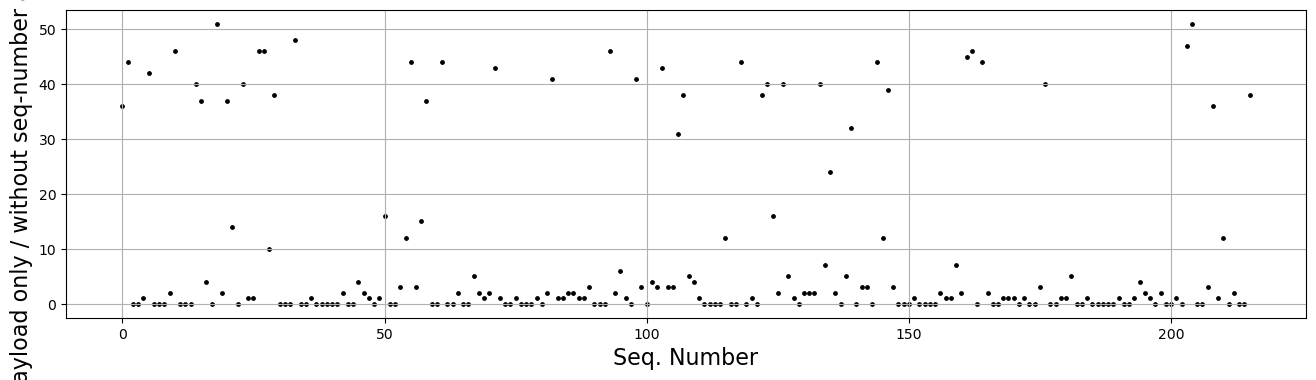

In [20]:
# BER for each packet
print("Note: if individual packets have a high bit-error rate, it could be that the pseudo-sequence number was corrupted and the script could not identify the expected payload correctly.")
plt.scatter(range(len(df)), [compute_ber_packet(row,PACKET_LEN=NUM_16RND*2)[0] for (_,row) in df.iterrows()], marker='o', s=6, color='black')
plt.grid()
plt.ylabel('Bit Error Rate [%] (payload only / without seq-number and pseudo-seq-number)', fontsize=16)
plt.xlabel('Seq. Number', fontsize=16)

# Distance

## Definition

**The communication distance of the system.**
<br>$D_{1}$: the distance between carrier<->backscatter_tag[m]
<br>$D_{2}$: the distance between backscatter_tag<->receiver[m]
<br> Distance metric = $D_{1}^2D_{2}^2$
<br>

In [21]:
# record the distance
dis_carrier_tag = 1
dis_tag_rx = 4

dis_metric = dis_carrier_tag**2*dis_tag_rx**2
print(f"Distance metric is: {dis_metric}")

Distance metric is: 16


# Radarplot

**Please pay attention to the unit**
<br> <font color='red'>Time</font>: use second as unit
<br> <font color='red'>Reliability</font>: use the percent as unit
<br> <font color='red'>Distance</font>: use meter as unit
<br>**Metics = [Time(s), Reliability(%), Distance(m)]**
<br> <font color='red'>Always keep the reference in your plot.</font>
<br> Tips: for ploting, time metric uses $\frac{1}{Time}*1000$ as the time metric, the higher the value the better the system performance

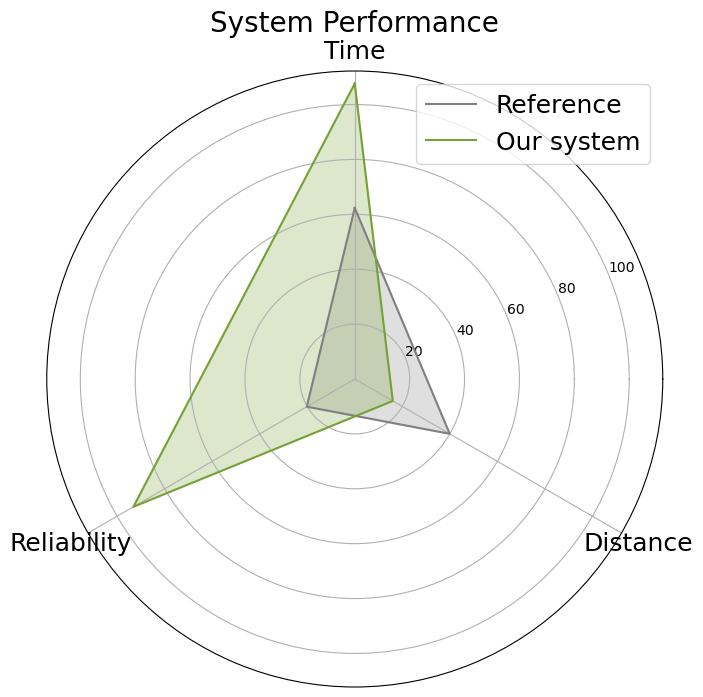

In [22]:
metrics = [file_delay_s, bit_reliability, dis_metric]
radar_plot(metrics)